# Mask & Depth Prediction Network

Dice Score for Mask: **0.9464220962827168** <br/>
Dice Score for Depth: **0.5222350945548405**

Input:- Foreground+Background , Background Image <br/>
Output:- Mask, Depth 

In [2]:
import numpy as np
import torch
import os
import torch.nn as nn                        
import torch.nn.functional as F             
import torch.optim as optim   
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from kornia.losses import SSIM   #git clone https://github.com/kornia/kornia.git  in current directory
from PIL import Image

from Custom_VAE import VAE
import dice_loss


## Train & Test Script

In [3]:
import sys
sys.path.append('../utils/') #Path for Training & Test/Evaluation Logic

from my_train_A15 import my_train
from my_test_A15 import my_test

## CustomDataset

In [4]:
class CustomDataset_Train(Dataset):
    def __init__(self, filepath, image_transform, mask_transform, depth_transform, datalen=360000):
        self.filepath = filepath
        self.length = datalen
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.depth_transform = depth_transform
    
    def __getitem__(self, index):
        index_id = index + 1

        bg = Image.open(self.filepath+'output_bg/'+str(index_id)+'.jpg')
        fgbg = Image.open(self.filepath+'output_image/'+str(index_id)+'.jpg')

        mask = Image.open(self.filepath+'output_mask/'+str(index_id)+'.jpg')
        depth = Image.open(self.filepath+'output_depth/'+str(index_id)+'.jpg')

        if self.image_transform:
            bg = self.image_transform(bg)
            fgbg = self.image_transform(fgbg)
        if self.mask_transform:  
            mask = self.mask_transform(mask)
        if self.depth_transform:  
            depth = self.depth_transform(depth)

        return bg, fgbg, mask, depth
    
    def __len__(self):
        return self.length

class CustomDataset_Test(Dataset):
    def __init__(self, filepath, image_transform, mask_transform, depth_transform, datalen=40000):
        self.filepath = filepath
        self.length = datalen
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.depth_transform = depth_transform

    def __getitem__(self, index):
        index_id = index + 1 + 360000

        bg = Image.open(self.filepath+'output_bg/'+str(index_id)+'.jpg')
        fgbg = Image.open(self.filepath+'output_image/'+str(index_id)+'.jpg')

        mask = Image.open(self.filepath+'output_mask/'+str(index_id)+'.jpg')
        depth = Image.open(self.filepath+'output_depth/'+str(index_id)+'.jpg')

        if self.image_transform:
            bg = self.image_transform(bg)
            fgbg = self.image_transform(fgbg)
        if self.mask_transform:  
            mask = self.mask_transform(mask)
        if self.depth_transform:  
            depth = self.depth_transform(depth)

        return bg, fgbg, mask, depth

    def __len__(self):
        return self.length

## DataLoader with Transforms

In [5]:
imgdim = 224
batchsize = 64
image_transform = transforms.Compose([ transforms.ToTensor() ])
    
mask_transform = transforms.Compose([ transforms.ToTensor() ])
    
depth_transform = transforms.Compose([ transforms.ToTensor() ])

# Dataset path for fgbg + bg + Mask + Depth Images
filepath='/root/images/'

train_dataset = CustomDataset_Train(filepath, image_transform=image_transform, mask_transform=mask_transform, depth_transform=depth_transform, datalen=360000 )
test_dataset = CustomDataset_Test(filepath, image_transform=image_transform, mask_transform=mask_transform, depth_transform=depth_transform, datalen=40000 )


train_loader = torch.utils.data.DataLoader(train_dataset,  batch_size=batchsize, num_workers=12,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, num_workers=12,shuffle=True)

## Model

In [6]:
device= 'cuda'
model = VAE(z_dim=40).to(device)
# model = SegNet().to(device)


## Prediction Visualization Logic on TestLoader

In [12]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt


def imshow(img,size=8):
    plt.figure(figsize=(size, size)) 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() 
    

def visualization (model, device, test_loader,size=8):
        model.eval()
        with torch.no_grad():
            bg, fgbg, mask, depth = next( iter(test_loader))
            bg, fgbg = bg.to(device), fgbg.to(device)    #Input
            mask, depth =  mask.to(device), depth.to(device) #output

            # Predict
            mask_pred, depth_pred =model(bg, fgbg)

            print("~~~~~~~~~~~~~~~~~~Input Image with Dog ~~~~~~~~~~~~~~~~~~")
            imshow(torchvision.utils.make_grid(fgbg.to('cpu')[1:6]),size)
        
        
            print("~~~~~~~~~~~~~~~~~~Mask Target ~~~~~~~~~~~~~~~~~~")
            imshow(torchvision.utils.make_grid(mask.to('cpu')[1:6]),size)
            print("~~~~~~~~~~~~~~~~~~Mask Prediction ~~~~~~~~~~~~~~~~~~")
            imshow(torchvision.utils.make_grid(mask_pred.to('cpu')[1:6]),size)

            print("~~~~~~~~~~~~~~~~~~Depth Target ~~~~~~~~~~~~~~~~~~")
            imshow(torchvision.utils.make_grid(depth.to('cpu')[1:6]),size)
            print("~~~~~~~~~~~~~~~~~~Depth Prediction ~~~~~~~~~~~~~~~~~~")
            imshow(torchvision.utils.make_grid(depth_pred.to('cpu')[1:6]),size)
        

## Training Model

In [8]:
from torch.optim.lr_scheduler import StepLR
criterion_mask = nn.BCEWithLogitsLoss()
# criterion_mask = nn.SmoothL1Loss()
# criterion_mask = nn.MSELoss()
# criterion_mask = nn.L1Loss()
criterion_depth = SSIM(3, reduction="mean" )
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9 ) 

train = my_train()

  0%|          | 0/5625 [00:00<?, ?it/s]

EPOCH: 0


 epoch=0  Batch_id=5624 Loss=0.03814055770635605 loss_mask=0.01853700913488865 loss_depth=0.04031873121857643 : 100%|██████████| 5625/5625 [1:14:23<00:00,  1.26it/s]   


~~~~~~~~~~~~~~~~~~Input Image with Dog ~~~~~~~~~~~~~~~~~~


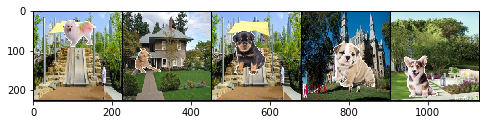

~~~~~~~~~~~~~~~~~~Mask Target ~~~~~~~~~~~~~~~~~~


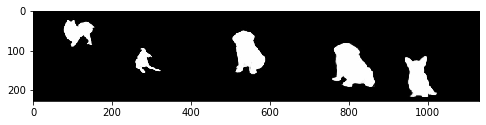

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


~~~~~~~~~~~~~~~~~~Mask Prediction ~~~~~~~~~~~~~~~~~~


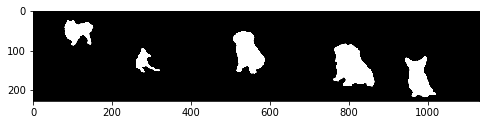

~~~~~~~~~~~~~~~~~~Depth Target ~~~~~~~~~~~~~~~~~~


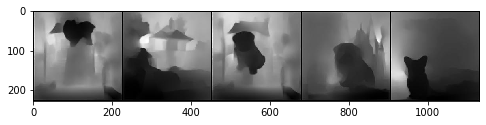

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


~~~~~~~~~~~~~~~~~~Depth Prediction ~~~~~~~~~~~~~~~~~~


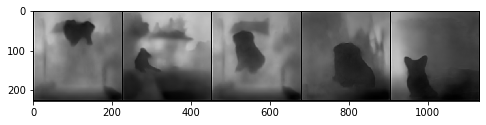

  0%|          | 0/5625 [00:00<?, ?it/s]

EPOCH: 1


 epoch=1  Batch_id=5624 Loss=0.028020458295941353 loss_mask=0.014115124009549618 loss_depth=0.029565496370196342 : 100%|██████████| 5625/5625 [1:15:12<00:00,  1.26it/s]


~~~~~~~~~~~~~~~~~~Input Image with Dog ~~~~~~~~~~~~~~~~~~


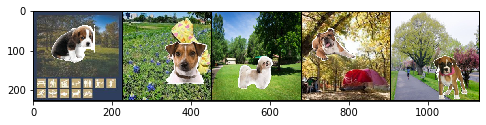

~~~~~~~~~~~~~~~~~~Mask Target ~~~~~~~~~~~~~~~~~~


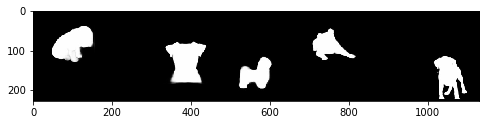

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


~~~~~~~~~~~~~~~~~~Mask Prediction ~~~~~~~~~~~~~~~~~~


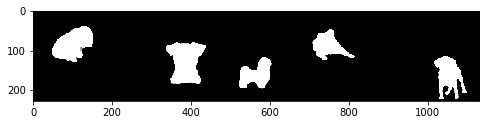

~~~~~~~~~~~~~~~~~~Depth Target ~~~~~~~~~~~~~~~~~~


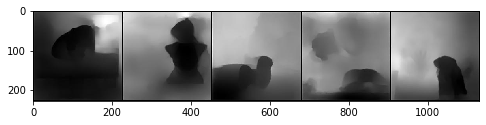

~~~~~~~~~~~~~~~~~~Depth Prediction ~~~~~~~~~~~~~~~~~~


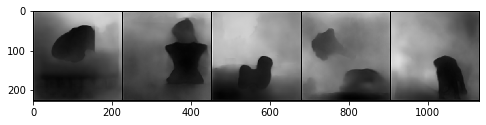

  0%|          | 0/5625 [00:00<?, ?it/s]

EPOCH: 2


 epoch=2  Batch_id=5624 Loss=0.024964699521660805 loss_mask=0.012544680386781693 loss_depth=0.026344703510403633 : 100%|██████████| 5625/5625 [1:14:26<00:00,  1.26it/s]


~~~~~~~~~~~~~~~~~~Input Image with Dog ~~~~~~~~~~~~~~~~~~


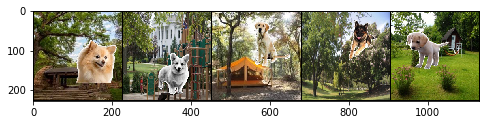

~~~~~~~~~~~~~~~~~~Mask Target ~~~~~~~~~~~~~~~~~~


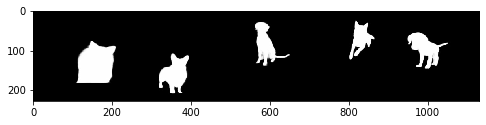

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


~~~~~~~~~~~~~~~~~~Mask Prediction ~~~~~~~~~~~~~~~~~~


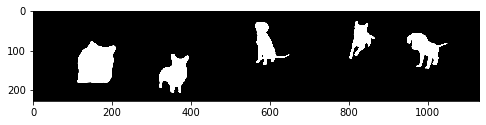

~~~~~~~~~~~~~~~~~~Depth Target ~~~~~~~~~~~~~~~~~~


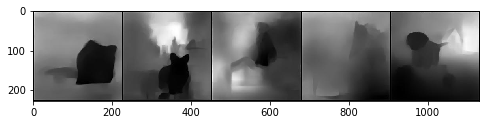

~~~~~~~~~~~~~~~~~~Depth Prediction ~~~~~~~~~~~~~~~~~~


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


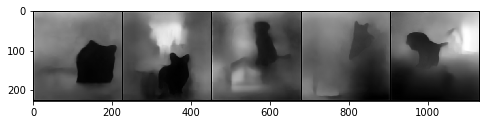

In [8]:
EPOCHS = 3
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer,  epoch, criterion_mask, criterion_depth, loss_ratio=0.1)
    visualization(model, device, test_loader)

In [10]:
torch.save(model,'result_model.pt')  # Save Model

In [9]:
# model = torch.load('result_model.pt')

## Dice Score on Test Dataset

In [10]:
test = my_test()

dice_mask, dice_depth = test(model, device, test_loader, criterion_mask, criterion_depth, loss_ratio=0.1)
print("Dice Score for Mask:",dice_mask)
print("Dice Score for Depth:",dice_depth)

 Loss=0.033058006316423416 loss_mask=0.025655098259449005 loss_depth=0.033880554139614105 : 100%|██████████| 63/63 [00:18<00:00,  4.29it/s]

Dice Score for Mask: 0.9461747568751139
Dice Score for Depth: 0.5220727154186794


## Prediction on Test Dataset

~~~~~~~~~~~~~~~~~~Input Image with Dog ~~~~~~~~~~~~~~~~~~


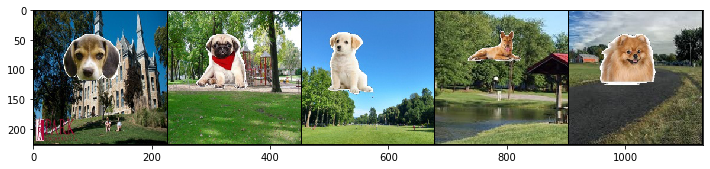

~~~~~~~~~~~~~~~~~~Mask Target ~~~~~~~~~~~~~~~~~~


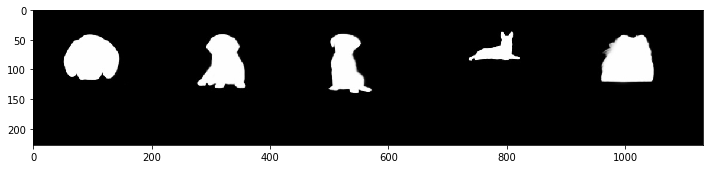

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


~~~~~~~~~~~~~~~~~~Mask Prediction ~~~~~~~~~~~~~~~~~~


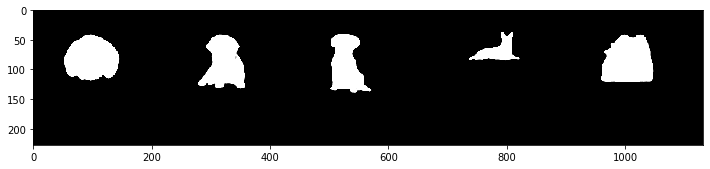

~~~~~~~~~~~~~~~~~~Depth Target ~~~~~~~~~~~~~~~~~~


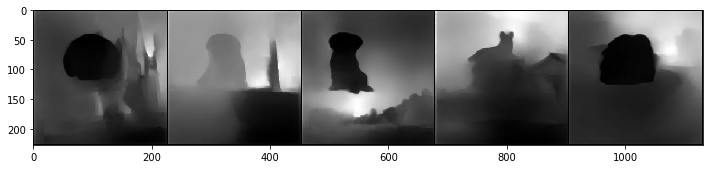

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


~~~~~~~~~~~~~~~~~~Depth Prediction ~~~~~~~~~~~~~~~~~~


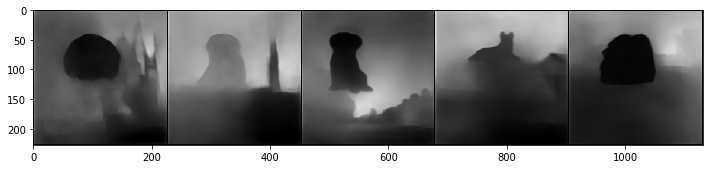

In [13]:
visualization(model, device, test_loader, 12)